In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `C:\Users\nicky\Documents\BME 574 Julia`


In [2]:
Pkg.add(["CSV","DataFrames","Flux","Statistics","Plots","Optimisers","StatsBase","Convex","SCS"])

   Resolving package versions...
  No Changes to `C:\Users\nicky\Documents\BME 574 Julia\Project.toml`
  No Changes to `C:\Users\nicky\Documents\BME 574 Julia\Manifest.toml`


In [3]:
using CSV, DataFrames, Flux, Statistics, Plots, Optimisers, StatsBase, Convex, SCS

### Initialize data

In [4]:
# load data
data = CSV.read("ecmo_platelets.txt", DataFrame; header = true)
data[!, :PlateletCount] = Float32.(data[!, :PlateletCount]);
data[!, :PlateletTrans] = Float32.(data[!, :PlateletTrans]);
data

Row,SubjectID,Time,PlateletCount,PlateletTrans
,Int64,Int64,Float32,Float32
1,1,-40,304.0,0.0
2,1,-36,245.0,0.0
3,1,-32,231.052,0.0
4,1,-28,226.0,0.0
5,1,-24,231.0,0.0
6,1,-20,201.0,0.0
7,1,-16,201.5,0.0
8,1,-12,202.0,0.0
9,1,-8,199.257,0.0


In [5]:
# sort by subjectid and time
sort!(data,[:SubjectID, :Time]);

# group by subjectid
grouped_data = groupby(data, :SubjectID);

In [6]:
# function to extract the sequences for each subject
function extract_sequences(grouped_data, feature_columns)
    return[group[!, feature_columns] for group in grouped_data]
end

extract_sequences (generic function with 1 method)

In [7]:
# extract count and trans sequences for each subject
features = [:PlateletCount, :PlateletTrans];
sequences = extract_sequences(grouped_data, features);

# plop into vector of vectors
input_data = [group.PlateletCount for group in grouped_data];
target_data = [group.PlateletTrans for group in grouped_data];

In [8]:
input_data[1], target_data[1]

(Float32[304.0, 245.0, 231.05159, 226.0, 231.0, 201.0, 201.5, 202.0, 199.25728, 192.0  …  45.361446, 43.0, 103.0, 95.60714, 80.0, 55.0, 47.07353, 44.0, 50.0, 35.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0])

In [9]:
# function to pad vectors (extend all time series to same length)
function pad_sequences(sequences, pad_value=0.0f0)
    max_len = maximum(length.(sequences))
    padded = [vcat(seq, fill(pad_value, max_len - length(seq))) for seq in sequences]
    mask = [vcat(ones(Int, length(seq)), Float32.(zeros(Int, max_len - length(seq)))) for seq in sequences]
    #return hcat(padded...), hcat(mask...)
    return padded, mask
end

pad_sequences (generic function with 2 methods)

In [10]:
# get padded 
input_padded, input_masks = pad_sequences(input_data);
target_padded, target_masks = pad_sequences(target_data);

In [11]:
input_padded[1], target_padded[1]

(Float32[304.0, 245.0, 231.05159, 226.0, 231.0, 201.0, 201.5, 202.0, 199.25728, 192.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [12]:
# convert to tensors
x = Flux.cpu(input_padded);
y = Flux.cpu(target_padded);
masks = Flux.cpu(input_masks);

In [13]:
x[1], y[1], masks[1]

(Float32[304.0, 245.0, 231.05159, 226.0, 231.0, 201.0, 201.5, 202.0, 199.25728, 192.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

### LASSO regression

In [14]:
# matrix A is # of subjects by # of measurements
A = 1 * transpose(reduce(hcat, x))

173×262 Matrix{Float32}:
 304.0  245.0     231.052   226.0    …    0.0   0.0   0.0     0.0      0.0
 196.0  172.333   162.167   160.0         0.0   0.0   0.0     0.0      0.0
 327.0  200.0     172.0     176.0         0.0   0.0   0.0     0.0      0.0
 249.0  248.866   248.444   247.706       0.0   0.0   0.0     0.0      0.0
 243.0  142.0     156.0     138.0         0.0   0.0   0.0     0.0      0.0
 211.0  178.0     178.0     178.0    …    0.0   0.0   0.0     0.0      0.0
 155.0  166.0     164.5     163.0         0.0   0.0   0.0     0.0      0.0
 185.0  207.0     180.0     159.0         0.0   0.0   0.0     0.0      0.0
 279.0  253.594   223.0     186.0         0.0   0.0   0.0     0.0      0.0
 308.0  234.0     216.5     194.0         0.0   0.0   0.0     0.0      0.0
 155.0  216.0     165.0     151.0    …    0.0   0.0   0.0     0.0      0.0
 199.0  194.593   182.407   164.0         0.0   0.0   0.0     0.0      0.0
 349.0  346.472   344.778   343.75       79.0  86.0  87.146  87.7952  88.0


In [15]:
# matrix B is # of events by # of subjects
B = 1 * transpose(reduce(hcat, y))

173×262 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [16]:
# confirm dimensionality w pseudoinverse
# X_pseudo is # of measurements by # of events
X_pseudo = A'*B

262×262 Matrix{Float32}:
 934.0    3712.0    5480.0   3917.0   …  0.0  154.0     0.0  0.0  0.0  0.0
 605.375  2139.42   3971.44  3041.26     0.0  157.724   0.0  0.0  0.0  0.0
 664.0    1831.5    3220.2   2384.88     0.0  164.891   0.0  0.0  0.0  0.0
 598.886  1747.89   3147.34  2405.21     0.0  174.0     0.0  0.0  0.0  0.0
 543.537  1774.7    3149.01  2538.92     0.0  191.479   0.0  0.0  0.0  0.0
 536.0    1662.75   2721.91  2050.29  …  0.0  213.906   0.0  0.0  0.0  0.0
 487.047  1467.09   2293.48  1620.07     0.0  225.0     0.0  0.0  0.0  0.0
 405.5    1213.06   2174.59  1578.4      0.0  221.737   0.0  0.0  0.0  0.0
 482.967  1091.97   2006.77  1556.92     0.0  212.03    0.0  0.0  0.0  0.0
 431.405  1022.47   1933.39  1414.24     0.0  196.0     0.0  0.0  0.0  0.0
 424.944  1026.66   1873.58  1340.35  …  0.0  132.0     0.0  0.0  0.0  0.0
 398.355  1005.22   1850.56  1293.76     0.0  128.0     0.0  0.0  0.0  0.0
 354.639   847.639  1544.93  1110.98     0.0  119.074   0.0  0.0  0.0  0.0


In [17]:
# visualize to confirm
i = sample(1:size(A,1),1)[1]
plot(A[i,:])
vline!(findall(x -> x == 1, B[i,:]))

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file://C:/Users/nicky/Documents/BME 574 Julia/In[17]#1:1\[90mIn[17]:1:1[0;0m]8;;\
[48;2;120;70;70m%[0;0m visualize to confirm
[90m╙ ── [0;0m[91mnot a unary operator[0;0m

In [19]:
# function for lasso regression
function lasso(A, y, λ1)
    (T, K) = (size(A, 1), (size(A,2),size(y,2)))
    Q = A'A / T
    c = A'y / T                      #c'b = Y'X*b

    x = Variable(K)              #define variables to optimize over
    L1 = quadform(x, Q; assume_psd=true)            #b'Q*b
    L2 = dot(c, x)                 #c'b
    L3 = norm(x, 1)                #sum(|b|)

    problem = minimize(L1 - 2 * L2 + λ1 * L3)
    solve!(problem, SCS.Optimizer; silent = true)
    return Convex.evaluate(x)
end

lasso (generic function with 1 method)

In [20]:
# generate X matrix; dimensions are # of measurements by # of events
X = lasso(A, B, 0.001)

262×262 Matrix{Float64}:
  0.001098      0.00442048    0.00255269  …  -2.20754e-6   0.0  0.0  0.0  0.0
 -0.00170854   -0.00519184   -0.00220851      1.22354e-6   0.0  0.0  0.0  0.0
  0.000560351   0.00213758    8.16041e-5     -1.07987e-6   0.0  0.0  0.0  0.0
 -0.001019     -0.00215589   -0.00414522     -4.54835e-6   0.0  0.0  0.0  0.0
  9.59491e-5   -0.00102604    0.0080116       7.97194e-6   0.0  0.0  0.0  0.0
  0.00478135    0.00319912   -0.00399711  …   7.39737e-6   0.0  0.0  0.0  0.0
 -0.00394964   -0.000875315   0.00107828      7.03007e-10  0.0  0.0  0.0  0.0
  0.000242018   0.0025789    -0.00207132     -3.1171e-12   0.0  0.0  0.0  0.0
  0.000159851  -0.00213662    0.00197034     -6.14673e-10  0.0  0.0  0.0  0.0
 -0.00255847   -0.00493927   -0.00330301      2.86551e-6   0.0  0.0  0.0  0.0
  0.00188168    0.00329785    0.00153846  …  -2.13545e-5   0.0  0.0  0.0  0.0
 -0.00194395   -3.79016e-5    0.00871495     -2.5955e-6    0.0  0.0  0.0  0.0
  0.00147478   -0.00303381   -0.0119693

### test overall result

In [21]:
# get resulting B from lasso 
B_lasso = A*X

173×262 Matrix{Float64}:
  0.0520603     0.00854341   …   0.000149268  0.0  0.0  0.0  0.0
 -0.0293697    -0.042295         0.000477967  0.0  0.0  0.0  0.0
 -0.00106703   -0.00265151       0.000170825  0.0  0.0  0.0  0.0
  0.000624745   0.0025085       -0.000773704  0.0  0.0  0.0  0.0
 -0.129133     -0.205827        -0.000248617  0.0  0.0  0.0  0.0
 -0.0592074    -0.341064     …  -0.00144623   0.0  0.0  0.0  0.0
 -0.0177921     0.00854273       0.000634911  0.0  0.0  0.0  0.0
  0.0250852    -0.0405267       -9.66062e-5   0.0  0.0  0.0  0.0
 -0.00347067   -0.00200211       0.000247671  0.0  0.0  0.0  0.0
  0.00393415    0.345145         0.000560182  0.0  0.0  0.0  0.0
  0.000742049   0.000946012  …   0.000183175  0.0  0.0  0.0  0.0
  0.105974      0.213874        -0.000906317  0.0  0.0  0.0  0.0
  6.87207e-5   -0.0135775        0.00260597   0.0  0.0  0.0  0.0
  ⋮                          ⋱                          ⋮    
 -0.0368363    -0.018261        -0.000866166  0.0  0.0  0.0  0.0
  0

In [22]:
# round B_lasso up and down around mean
B_lasso_round = B_lasso
for j = 1:length(B_lasso)
    if B_lasso[j] > mean(B_lasso)
        B_lasso_round[j] = 1
    else
        B_lasso_round[j] = 0
    end
end
B_lasso_round

173×262 Matrix{Float64}:
 1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [23]:
# determine accuracy of B_lasso
for k = 1:size(B,1)
    subject_acc = sum(B[k,:] .* B_lasso_round[k,:])/sum(B[k,:])*100
    println("Subject ", k, " --- Accuracy: ", subject_acc, "%")
end

sum(B .* B_lasso_round)/sum(B)*100

Subject 1 --- Accuracy: 100.0%
Subject 2 --- Accuracy: 100.0%
Subject 3 --- Accuracy: NaN%
Subject 4 --- Accuracy: 100.0%
Subject 5 --- Accuracy: 100.0%
Subject 6 --- Accuracy: NaN%
Subject 7 --- Accuracy: 100.0%
Subject 8 --- Accuracy: 100.0%
Subject 9 --- Accuracy: 100.0%
Subject 10 --- Accuracy: NaN%
Subject 11 --- Accuracy: 100.0%
Subject 12 --- Accuracy: 100.0%
Subject 13 --- Accuracy: 100.0%
Subject 14 --- Accuracy: NaN%
Subject 15 --- Accuracy: 100.0%
Subject 16 --- Accuracy: 100.0%
Subject 17 --- Accuracy: 100.0%
Subject 18 --- Accuracy: 100.0%
Subject 19 --- Accuracy: 100.0%
Subject 20 --- Accuracy: 100.0%
Subject 21 --- Accuracy: 100.0%
Subject 22 --- Accuracy: 100.0%
Subject 23 --- Accuracy: 100.0%
Subject 24 --- Accuracy: 100.0%
Subject 25 --- Accuracy: 100.0%
Subject 26 --- Accuracy: 100.0%
Subject 27 --- Accuracy: 100.0%
Subject 28 --- Accuracy: 100.0%
Subject 29 --- Accuracy: 100.0%
Subject 30 --- Accuracy: NaN%
Subject 31 --- Accuracy: 100.0%
Subject 32 --- Accuracy: 10

100.0

In [24]:
# random subject
i = sample(1:size(A,1),1)[1]
#i=__

112

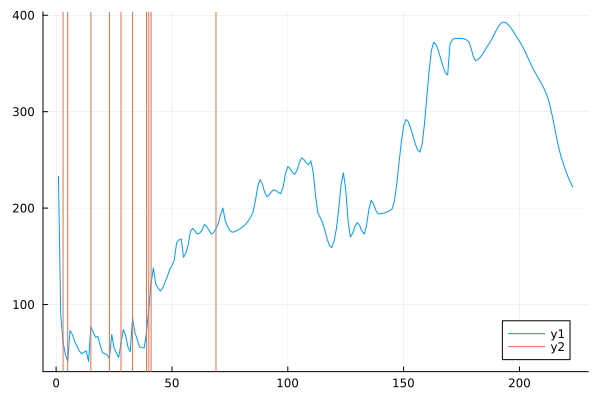

In [25]:
# plot actual data
plot(input_data[i])
vline!(findall(x -> x == 1, B[i,:]))

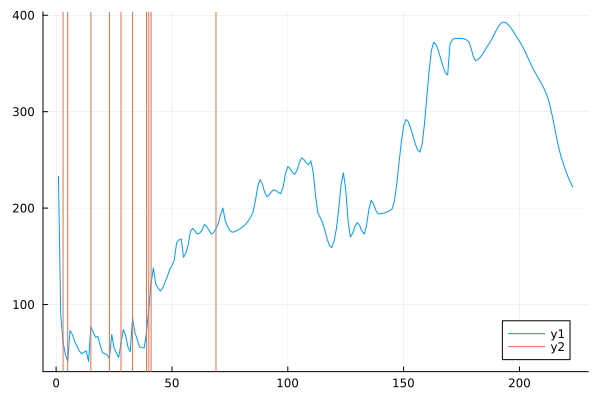

In [26]:
# plot predicted data
plot(input_data[i])
vline!(findall(x -> x == 1, B_lasso_round[i,:]))

### test a smaller set of data

In [27]:
# generate test set
idx = sort(sample(1:size(A,1),15));
A_test = A[idx,:];
B_test = B[idx,:];

In [28]:
B_test_lasso = A_test * X

15×262 Matrix{Float64}:
  0.00393415    0.345145     …   0.000560182  0.0  0.0  0.0  0.0
 -0.0269123    -0.042605         0.00109614   0.0  0.0  0.0  0.0
 -0.00157646   -0.00111336       7.81762e-5   0.0  0.0  0.0  0.0
 -0.00333864   -0.00792707      -0.000320317  0.0  0.0  0.0  0.0
  0.177991      0.410909         1.0344e-5    0.0  0.0  0.0  0.0
 -0.0792393    -0.0158742    …   1.79386e-5   0.0  0.0  0.0  0.0
 -0.00430884    0.000585524     -0.000645523  0.0  0.0  0.0  0.0
 -0.199464     -0.298075        -0.000275494  0.0  0.0  0.0  0.0
 -0.199464     -0.298075        -0.000275494  0.0  0.0  0.0  0.0
  0.138527     -0.0504917       -0.000243601  0.0  0.0  0.0  0.0
 -0.030426      0.044972     …  -0.000750638  0.0  0.0  0.0  0.0
 -0.120251      0.0979217        0.000547815  0.0  0.0  0.0  0.0
  0.000973182   0.000184921     -0.000174132  0.0  0.0  0.0  0.0
 -0.000963451   0.00239709       0.000189046  0.0  0.0  0.0  0.0
 -0.00335002    0.00210085      -0.000753191  0.0  0.0  0.0  0.0

In [29]:
# round B_test_lasso up and down around mean
B_test_lasso_round = B_test_lasso
for j = 1:length(B_test_lasso)
    if B_test_lasso[j] > mean(B_test_lasso)
        B_test_lasso_round[j] = 1
    else
        B_test_lasso_round[j] = 0
    end
end
B_test_lasso_round

15×262 Matrix{Float64}:
 0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [30]:
# determine accuracy of B_test_lasso
for k = 1:size(B_test,1)
    subject_acc = sum(B_test[k,:] .* B_test_lasso_round[k,:])/sum(B_test[k,:])*100
    println("Subject ", idx[k], " --- Accuracy: ", subject_acc, "%")
end

Subject 10 --- Accuracy: NaN%
Subject 24 --- Accuracy: 100.0%
Subject 69 --- Accuracy: 100.0%
Subject 76 --- Accuracy: NaN%
Subject 78 --- Accuracy: 100.0%
Subject 81 --- Accuracy: 100.0%
Subject 87 --- Accuracy: 100.0%
Subject 91 --- Accuracy: 100.0%
Subject 91 --- Accuracy: 100.0%
Subject 100 --- Accuracy: NaN%
Subject 121 --- Accuracy: 100.0%
Subject 122 --- Accuracy: NaN%
Subject 158 --- Accuracy: 100.0%
Subject 171 --- Accuracy: 100.0%
Subject 173 --- Accuracy: NaN%


In [37]:
# random subject from test set
i = sample(idx,1)[1]
#i=__

100

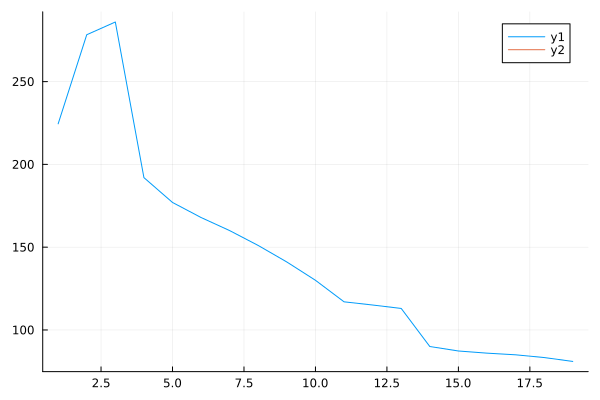

In [38]:
# plot actual data
plot(input_data[i])
vline!(findall(x -> x == 1, B[i,:]))

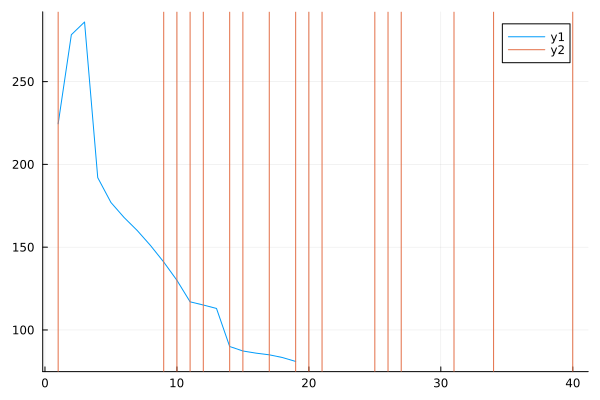

In [39]:
# plot predicted data
plot(input_data[i])
vline!(findall(x -> x == 1, B_lasso_round[i,:]))

The LASSO regression was a very iffy model to use for this purpose. It was either able to determine absolutely no events or all the events plus some, meaning that there was an issue with both underfitting and overfitting.